# Analysis of FAIR metrics

In this notebook, the retrieved results of the FAIR metrics collection is analyzed.

In [1]:
from datetime import date
import statistics
from collections import Counter
from pathlib import Path
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns
from scipy import stats

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

Folders and constants

In [3]:
# subset variable is used to run the notebook for all users, only individual 
# accounts or organisations (group)
subset = "all"  # "user", "group", "all"

# todo make this into something nice
how_fair_is = pd.read_csv("results/howfairis.csv")
languages = pd.read_csv("results/languages.csv")
contributors = pd.read_csv("results/contributors.csv")
topics = pd.read_csv("results/topics.csv")
installations = pd.read_csv("results/download_stats.csv")


# file paths
fp_repos = Path("..", "collect_repositories", "results", "repositories_filtered.csv")
fp_figs = Path("figs")

# create output folder if not exists
fp_figs.mkdir(exist_ok=True)

In [4]:
subset

'all'

## Load filtered repositories
Load (manually) filtered repositories into notebook.

In [6]:
repos = pd.read_csv(fp_repos)

## Filtering for research groups or private users only

In [7]:
users = pd.read_excel("../collect_users/results/users_enriched.xlsx")

In [8]:
def add_research_group_filter(dataset):
    user_is_research_group = []
    for row in dataset.iterrows():
        try:
            owner = row[1]['owner']
        except:
            owner = row[1]['html_url_repository'].split('/')[-2]
            
            
      
        row_users = users.loc[users['user_id'] == owner]
        if len(row_users['is_research_group']) == 0:
            user_is_research_group.append(False)
        for i in row_users['is_research_group']:
            if i == 1:
                user_is_research_group.append(True)
                break
            else:
                user_is_research_group.append(False)
                break
                    
    return user_is_research_group
    

In [9]:
repos['is_research_group'] = add_research_group_filter(repos)
contributors['is_research_group'] = add_research_group_filter(contributors)
topics['is_research_group'] = add_research_group_filter(topics)
languages['is_research_group'] = add_research_group_filter(languages)
how_fair_is['is_research_group'] = add_research_group_filter(how_fair_is)

## Subset repositories
Make a subset of repositories on "user", "group", or "all".

- "user" - Account of individual researcher
- "group" - Account of research group
- "all" - Both individual researcher or research group

In [9]:
if subset == "user":
    repos = repos[~repos['is_research_group']]
    contributors = contributors[~contributors['is_research_group']]
    topics = topics[~topics['is_research_group']]
    languages = languages[~languages['is_research_group']]
    how_fair_is = how_fair_is[~how_fair_is['is_research_group']]
elif subset == "group":
    repos = repos[repos['is_research_group']]
    contributors = contributors[contributors['is_research_group']]
    topics = topics[topics['is_research_group']]
    languages = languages[languages['is_research_group']]
    how_fair_is = how_fair_is[how_fair_is['is_research_group']]

## Datasets

Using the github API and the Howfairis software, we collected data on the repositories, their FAIRness, the languages used in the repository, the amount of contributors for each repository and the topics mentoined in each repository. 

The Howfairis software gives  boolean value on five measures of FAIRness for each repository. These five measures consist of having a repository (which is always True for our dataset), having a license, being available in a registry, allowing citation of the software and following the FAIR software quality checklist. Below, the first five rows of the datasets are displayed. 

In [10]:
repos

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,is_template,topics,visibility,forks,open_issues,watchers,default_branch,permissions,date,is_research_group
0,393154427,MDEwOlJlcG9zaXRvcnkzOTMxNTQ0Mjc=,bert-chinese-classifier,a-quei/bert-chinese-classifier,False,a-quei,https://github.com/a-quei/bert-chinese-classifier,NaN,False,https://api.github.com/repos/a-quei/bert-chine...,...,False,[],public,0,0,2,main,NaN,2022-01-14,False
1,114394344,MDEwOlJlcG9zaXRvcnkxMTQzOTQzNDQ=,guanyi.cls,a-quei/guanyi.cls,False,a-quei,https://github.com/a-quei/guanyi.cls,A costumed article class for latex,False,https://api.github.com/repos/a-quei/guanyi.cls,...,False,[],public,0,0,0,master,NaN,2022-01-14,False
2,306983465,MDEwOlJlcG9zaXRvcnkzMDY5ODM0NjU=,mtuna-annotated,a-quei/mtuna-annotated,False,a-quei,https://github.com/a-quei/mtuna-annotated,The annotated MTUNA corpus,False,https://api.github.com/repos/a-quei/mtuna-anno...,...,False,[],public,0,0,0,main,NaN,2022-01-14,False
3,393154581,MDEwOlJlcG9zaXRvcnkzOTMxNTQ1ODE=,probe-neuralreg,a-quei/probe-neuralreg,False,a-quei,https://github.com/a-quei/probe-neuralreg,NaN,False,https://api.github.com/repos/a-quei/probe-neur...,...,False,[],public,0,0,2,main,NaN,2022-01-14,False
4,208407337,MDEwOlJlcG9zaXRvcnkyMDg0MDczMzc=,qtuna,a-quei/qtuna,False,a-quei,https://github.com/a-quei/qtuna,"The QTuna Dataset, which is detailed in the pa...",False,https://api.github.com/repos/a-quei/qtuna,...,False,[],public,1,0,0,master,NaN,2022-01-14,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,24751970,MDEwOlJlcG9zaXRvcnkyNDc1MTk3MA==,SoftwareProject,wouter-swierstra/SoftwareProject,False,wouter-swierstra,https://github.com/wouter-swierstra/SoftwarePr...,NaN,False,https://api.github.com/repos/wouter-swierstra/...,...,False,[],public,1,0,0,master,NaN,2022-01-14,False
1414,4482341,MDEwOlJlcG9zaXRvcnk0NDgyMzQx,xmonad,wouter-swierstra/xmonad,False,wouter-swierstra,https://github.com/wouter-swierstra/xmonad,xmonad in Coq,False,https://api.github.com/repos/wouter-swierstra/...,...,False,[],public,8,0,39,master,NaN,2022-01-14,False
1415,260446603,MDEwOlJlcG9zaXRvcnkyNjA0NDY2MDM=,uu-rdms-excel,zievathustra/uu-rdms-excel,False,zievathustra,https://github.com/zievathustra/uu-rdms-excel,NaN,False,https://api.github.com/repos/zievathustra/uu-r...,...,False,[],public,0,0,0,master,NaN,2022-01-14,False
1416,251679358,MDEwOlJlcG9zaXRvcnkyNTE2NzkzNTg=,uu-rdms-harvest,zievathustra/uu-rdms-harvest,False,zievathustra,https://github.com/zievathustra/uu-rdms-harvest,Repository for projects on harvesting data per...,False,https://api.github.com/repos/zievathustra/uu-r...,...,False,[],public,0,0,0,master,NaN,2022-01-14,False


In [11]:
repos["owner"].value_counts()

UiL-OTS-labs              99
UtrechtUniversity         81
CLARIAH                   76
cjvanlissa                56
UUDigitalHumanitieslab    45
                          ..
FridoF                     1
pimlai                     1
sara-vanerp                1
Gionimo                    1
M-thieu                    1
Name: owner, Length: 139, dtype: int64

In [12]:
how_fair_is

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,watchers,default_branch,permissions,date,howfairis_repository,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist,is_research_group
0,393154427,MDEwOlJlcG9zaXRvcnkzOTMxNTQ0Mjc=,bert-chinese-classifier,a-quei/bert-chinese-classifier,False,a-quei,https://github.com/a-quei/bert-chinese-classifier,NaN,False,https://api.github.com/repos/a-quei/bert-chine...,...,2,main,NaN,2022-01-16,True,False,False,False,False,False
1,114394344,MDEwOlJlcG9zaXRvcnkxMTQzOTQzNDQ=,guanyi.cls,a-quei/guanyi.cls,False,a-quei,https://github.com/a-quei/guanyi.cls,A costumed article class for latex,False,https://api.github.com/repos/a-quei/guanyi.cls,...,0,master,NaN,2022-01-16,True,True,False,False,False,False
2,306983465,MDEwOlJlcG9zaXRvcnkzMDY5ODM0NjU=,mtuna-annotated,a-quei/mtuna-annotated,False,a-quei,https://github.com/a-quei/mtuna-annotated,The annotated MTUNA corpus,False,https://api.github.com/repos/a-quei/mtuna-anno...,...,0,main,NaN,2022-01-16,True,False,False,False,False,False
3,393154581,MDEwOlJlcG9zaXRvcnkzOTMxNTQ1ODE=,probe-neuralreg,a-quei/probe-neuralreg,False,a-quei,https://github.com/a-quei/probe-neuralreg,NaN,False,https://api.github.com/repos/a-quei/probe-neur...,...,2,main,NaN,2022-01-16,True,False,False,False,False,False
4,208407337,MDEwOlJlcG9zaXRvcnkyMDg0MDczMzc=,qtuna,a-quei/qtuna,False,a-quei,https://github.com/a-quei/qtuna,"The QTuna Dataset, which is detailed in the pa...",False,https://api.github.com/repos/a-quei/qtuna,...,0,master,NaN,2022-01-16,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,24751970,MDEwOlJlcG9zaXRvcnkyNDc1MTk3MA==,SoftwareProject,wouter-swierstra/SoftwareProject,False,wouter-swierstra,https://github.com/wouter-swierstra/SoftwarePr...,NaN,False,https://api.github.com/repos/wouter-swierstra/...,...,0,master,NaN,2022-01-16,True,False,False,False,False,False
1414,4482341,MDEwOlJlcG9zaXRvcnk0NDgyMzQx,xmonad,wouter-swierstra/xmonad,False,wouter-swierstra,https://github.com/wouter-swierstra/xmonad,xmonad in Coq,False,https://api.github.com/repos/wouter-swierstra/...,...,39,master,NaN,2022-01-16,True,True,False,False,False,False
1415,260446603,MDEwOlJlcG9zaXRvcnkyNjA0NDY2MDM=,uu-rdms-excel,zievathustra/uu-rdms-excel,False,zievathustra,https://github.com/zievathustra/uu-rdms-excel,NaN,False,https://api.github.com/repos/zievathustra/uu-r...,...,0,master,NaN,2022-01-16,True,False,False,False,False,False
1416,251679358,MDEwOlJlcG9zaXRvcnkyNTE2NzkzNTg=,uu-rdms-harvest,zievathustra/uu-rdms-harvest,False,zievathustra,https://github.com/zievathustra/uu-rdms-harvest,Repository for projects on harvesting data per...,False,https://api.github.com/repos/zievathustra/uu-r...,...,0,master,NaN,2022-01-16,True,True,False,False,False,False


In [19]:
languages

,html_url_repository,language,num_chars,date,is_research_group
0,https://github.com/a-quei/guanyi.cls,TeX,6531,2022-01-16,False
1,https://github.com/a-quei/quantified-descripti...,Python,44840,2022-01-16,False
2,https://github.com/a-quei/simplenlg-zh,Java,982116,2022-01-16,False
3,https://github.com/a-quei/simplenlg-zh,HTML,15617,2022-01-16,False
4,https://github.com/AJueling/AMWG,Shell,654532,2022-01-16,False
...,...,...,...,...,...
2750,https://github.com/wouter-swierstra/xmonad,Haskell,5601,2022-01-16,False
2751,https://github.com/zievathustra/uu-rdms-excel,VBA,1343,2022-01-16,False
2752,https://github.com/zievathustra/uu-rdms-harvest,Python,29341,2022-01-16,False
2753,https://github.com/zievathustra/uu-rdms-ris-pu...,TSQL,134593,2022-01-16,False


In [13]:
contributors

,html_url_repository,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,...,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,site_admin,contributions,date,is_research_group
0,https://github.com/a-quei/bert-chinese-classifier,a-quei,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,https://api.github.com/users/a-quei/followers,https://api.github.com/users/a-quei/following{...,...,https://api.github.com/users/a-quei/subscriptions,https://api.github.com/users/a-quei/orgs,https://api.github.com/users/a-quei/repos,https://api.github.com/users/a-quei/events{/pr...,https://api.github.com/users/a-quei/received_e...,User,False,1,2022-01-16,False
1,https://github.com/a-quei/guanyi.cls,a-quei,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,https://api.github.com/users/a-quei/followers,https://api.github.com/users/a-quei/following{...,...,https://api.github.com/users/a-quei/subscriptions,https://api.github.com/users/a-quei/orgs,https://api.github.com/users/a-quei/repos,https://api.github.com/users/a-quei/events{/pr...,https://api.github.com/users/a-quei/received_e...,User,False,7,2022-01-16,False
2,https://github.com/a-quei/mtuna-annotated,a-quei,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,https://api.github.com/users/a-quei/followers,https://api.github.com/users/a-quei/following{...,...,https://api.github.com/users/a-quei/subscriptions,https://api.github.com/users/a-quei/orgs,https://api.github.com/users/a-quei/repos,https://api.github.com/users/a-quei/events{/pr...,https://api.github.com/users/a-quei/received_e...,User,False,1,2022-01-16,False
3,https://github.com/a-quei/probe-neuralreg,a-quei,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,https://api.github.com/users/a-quei/followers,https://api.github.com/users/a-quei/following{...,...,https://api.github.com/users/a-quei/subscriptions,https://api.github.com/users/a-quei/orgs,https://api.github.com/users/a-quei/repos,https://api.github.com/users/a-quei/events{/pr...,https://api.github.com/users/a-quei/received_e...,User,False,2,2022-01-16,False
4,https://github.com/a-quei/qtuna,a-quei,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,https://api.github.com/users/a-quei/followers,https://api.github.com/users/a-quei/following{...,...,https://api.github.com/users/a-quei/subscriptions,https://api.github.com/users/a-quei/orgs,https://api.github.com/users/a-quei/repos,https://api.github.com/users/a-quei/events{/pr...,https://api.github.com/users/a-quei/received_e...,User,False,8,2022-01-16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,https://github.com/wouter-swierstra/SoftwarePr...,wouter-swierstra,1588245,MDQ6VXNlcjE1ODgyNDU=,https://avatars.githubusercontent.com/u/158824...,NaN,https://api.github.com/users/wouter-swierstra,https://github.com/wouter-swierstra,https://api.github.com/users/wouter-swierstra/...,https://api.github.com/users/wouter-swierstra/...,...,https://api.github.com/users/wouter-swierstra/...,https://api.github.com/users/wouter-swierstra/...,https://api.github.com/users/wouter-swierstra/...,https://api.github.com/users/wouter-swierstra/...,https://api.github.com/users/wouter-swierstra/...,User,False,3,2022-01-16,False
2633,https://github.com/wouter-swierstra/xmonad,norm2782,19933,MDQ6VXNlcjE5OTMz,https://avatars.githubusercontent.com/u/19933?v=4,NaN,https://api.github.com/users/norm2782,https://github.com/norm2782,https://api.github.com/users/norm2782/followers,https://api.github.

In [14]:
topics

,html_url_repository,topic,date,is_research_group
0,https://github.com/alexandrosstergiou/Bootstra...,bootstrap,2022-01-16,False
1,https://github.com/alexandrosstergiou/Bootstra...,data-analysis,2022-01-16,False
2,https://github.com/alexandrosstergiou/Bootstra...,data-normalization,2022-01-16,False
3,https://github.com/alexandrosstergiou/Bootstra...,data-science,2022-01-16,False
4,https://github.com/alexandrosstergiou/Bootstra...,decision-making,2022-01-16,False
...,...,...,...,...
1109,https://github.com/vankesteren/tensorsem,computation-graph,2022-01-16,False
1110,https://github.com/vankesteren/tensorsem,lavaan,2022-01-16,False
1111,https://github.com/vankesteren/tensorsem,sem,2022-01-16,False
1112,https://github.com/vankesteren/tensorsem,torch,2022-01-16,False


In [15]:
print("The repository data from Github contains the following columns:")
print(repos.columns)

The repository data from Github contains the following columns:
Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url',
       'description', 'fork', 'url', 'forks_url', 'keys_url',
       'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url',
       'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url',
       'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url',
       'languages_url', 'stargazers_url', 'contributors_url',
       'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url',
       'comments_url', 'issue_comment_url', 'contents_url', 'compare_url',
       'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url',
       'milestones_url', 'notifications_url', 'labels_url', 'releases_url',
       'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url',
       'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size',
       'stargazers_count', 'watchers_count', 'language', 'has_i

## Sofware licenses 

A license is important because it shows that people have permission to use and modify your code. The plots below show the licenses used in the collection. 


In [16]:
# short names for licenses
licenses_abbr = {
    'MIT License': 'MIT',
    'GNU General Public License v3.0': 'GPLv3',
    'Other': 'Other',
    'Apache License 2.0': 'Apache 2.0',
    'GNU General Public License v2.0': 'GPLv2',
    'BSD 3-Clause "New" or "Revised" License': 'BSD 3-Clause',
    'Creative Commons Attribution 4.0 International': 'CC-BY',
    'Creative Commons Zero v1.0 Universal': 'CC0',
    'GNU Lesser General Public License v3.0': 'LGPLv3',
    'The Unlicense': 'Unlicense',
    'GNU Affero General Public License v3.0': 'AGPPLv3',
    'BSD 2-Clause "Simplified" License': 'BSD 2-Clause',
    'Mozilla Public License 2.0': 'MPL 2.0',
    'GNU Lesser General Public License v2.1': 'LGPLv2.1',
    'Creative Commons Attribution Share Alike 4.0 International': 'CC-BY-SA',
    'ISC License': 'ISC'
    
}

In [17]:
# # all licences
# repos["license"].value_counts().plot(kind='bar', title = 'All licences')
# plt.savefig(Path(fp_figs, f'licenses_all_{subset}.png'), bbox_inches="tight")


In [18]:
# top most used 10 licences
top_10_licenses = repos["license"].value_counts().head(10)
print(top_10_licenses)

MIT License                                       261
GNU General Public License v3.0                   170
Other                                              86
Apache License 2.0                                 74
GNU General Public License v2.0                    50
BSD 3-Clause "New" or "Revised" License            32
Creative Commons Attribution 4.0 International     27
Creative Commons Zero v1.0 Universal               16
The Unlicense                                       7
GNU Lesser General Public License v3.0              7
Name: license, dtype: int64


/opt/homebrew/Caskroom/miniforge/base/envs/asreview_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


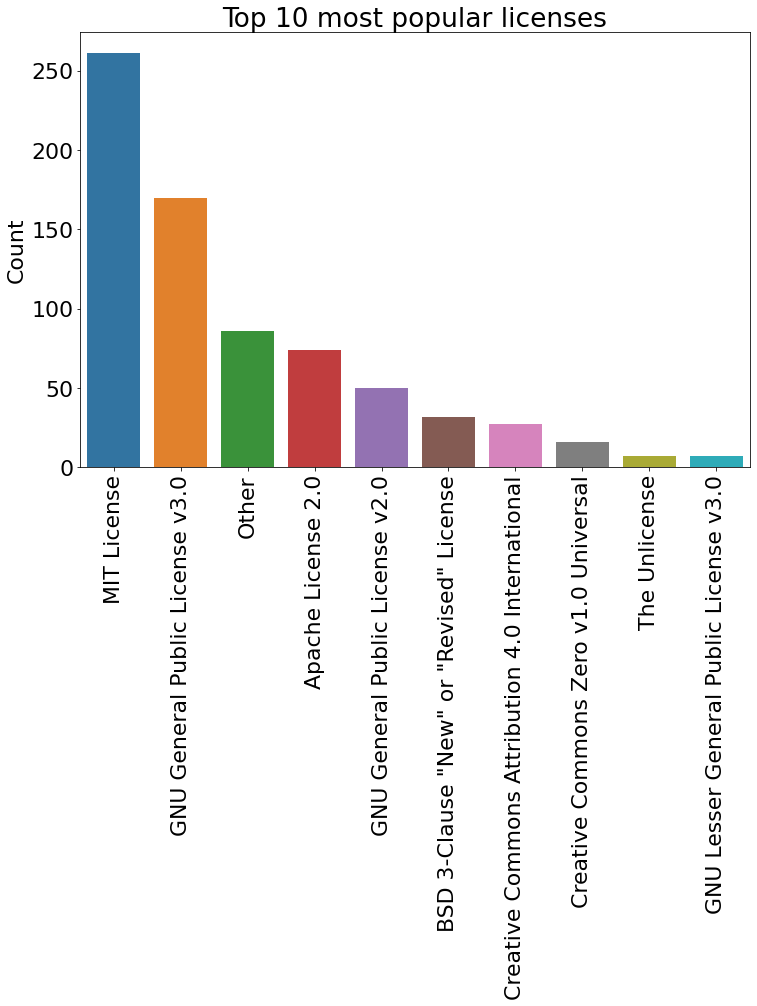

In [19]:
ax = sns.barplot(top_10_licenses.index, top_10_licenses)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Top 10 most popular licenses")

plt.savefig(Path(fp_figs, f'licenses_first10_{subset}.png'), bbox_inches="tight")

/opt/homebrew/Caskroom/miniforge/base/envs/asreview_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


MIT             261
GPLv3           170
Other            86
Apache 2.0       74
GPLv2            50
BSD 3-Clause     32
CC-BY            27
CC0              16
Unlicense         7
LGPLv3            7
Name: license, dtype: int64


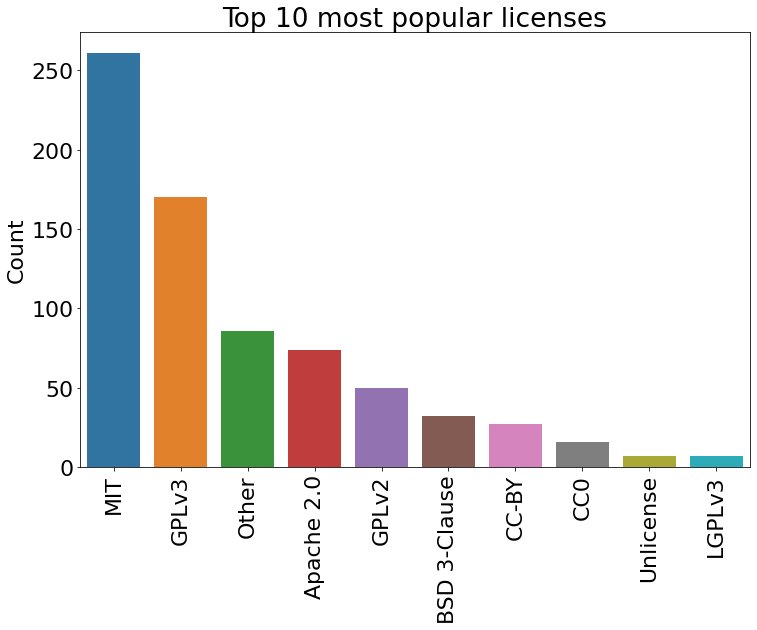

In [20]:
top_10_licenses_short = repos["license"].replace(licenses_abbr).value_counts().head(10)
print(top_10_licenses_short)

# first 10 licences with short names
ax = sns.barplot(top_10_licenses_short.index, top_10_licenses_short)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Top 10 most popular licenses")

plt.savefig(Path(fp_figs, f'licenses_short_first10_{subset}.png'), bbox_inches="tight")

/opt/homebrew/Caskroom/miniforge/base/envs/asreview_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


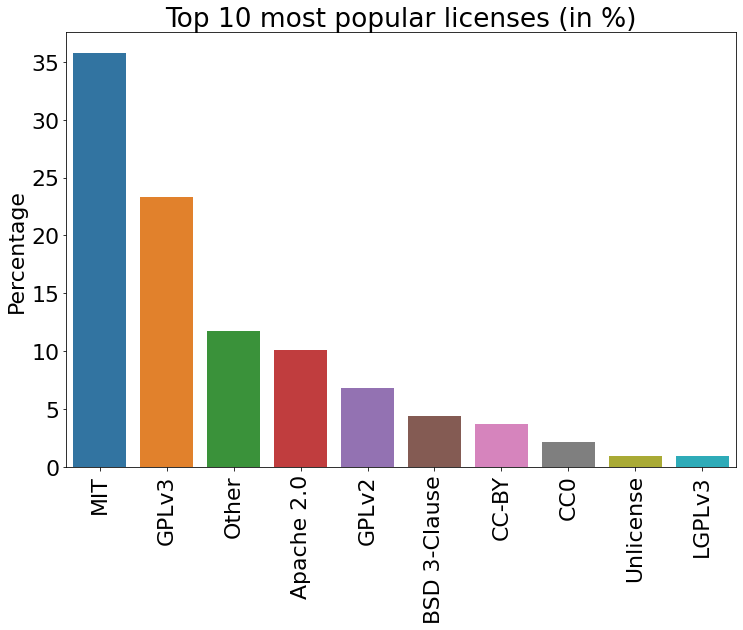

In [21]:
# first 10 licences with short names
ax = sns.barplot(top_10_licenses_short.index, top_10_licenses_short / top_10_licenses_short.sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular licenses (in %)")

plt.savefig(Path(fp_figs, f'licenses_short_first10_percentage_{subset}.png'), bbox_inches="tight")

Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

In [22]:
percentage_license = round(float(repos["license"].isna().sum()/len(repos)* 100),2)
print("{} % of repositories have a license on their page".format(percentage_license))

47.25 % of repositories have a license on their page


## Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

### Jupyter Notebooks

Please note that due to the way GitHub calculates the dominant language in a repository, Jupyter Notebooks tend to be the top language if used in a repository. The top language is determined by the number of characters, which is usually much larger in Jupyter Notebook files compared to for example Python scripts.

In [22]:
repos["language"].value_counts().shape

(51,)

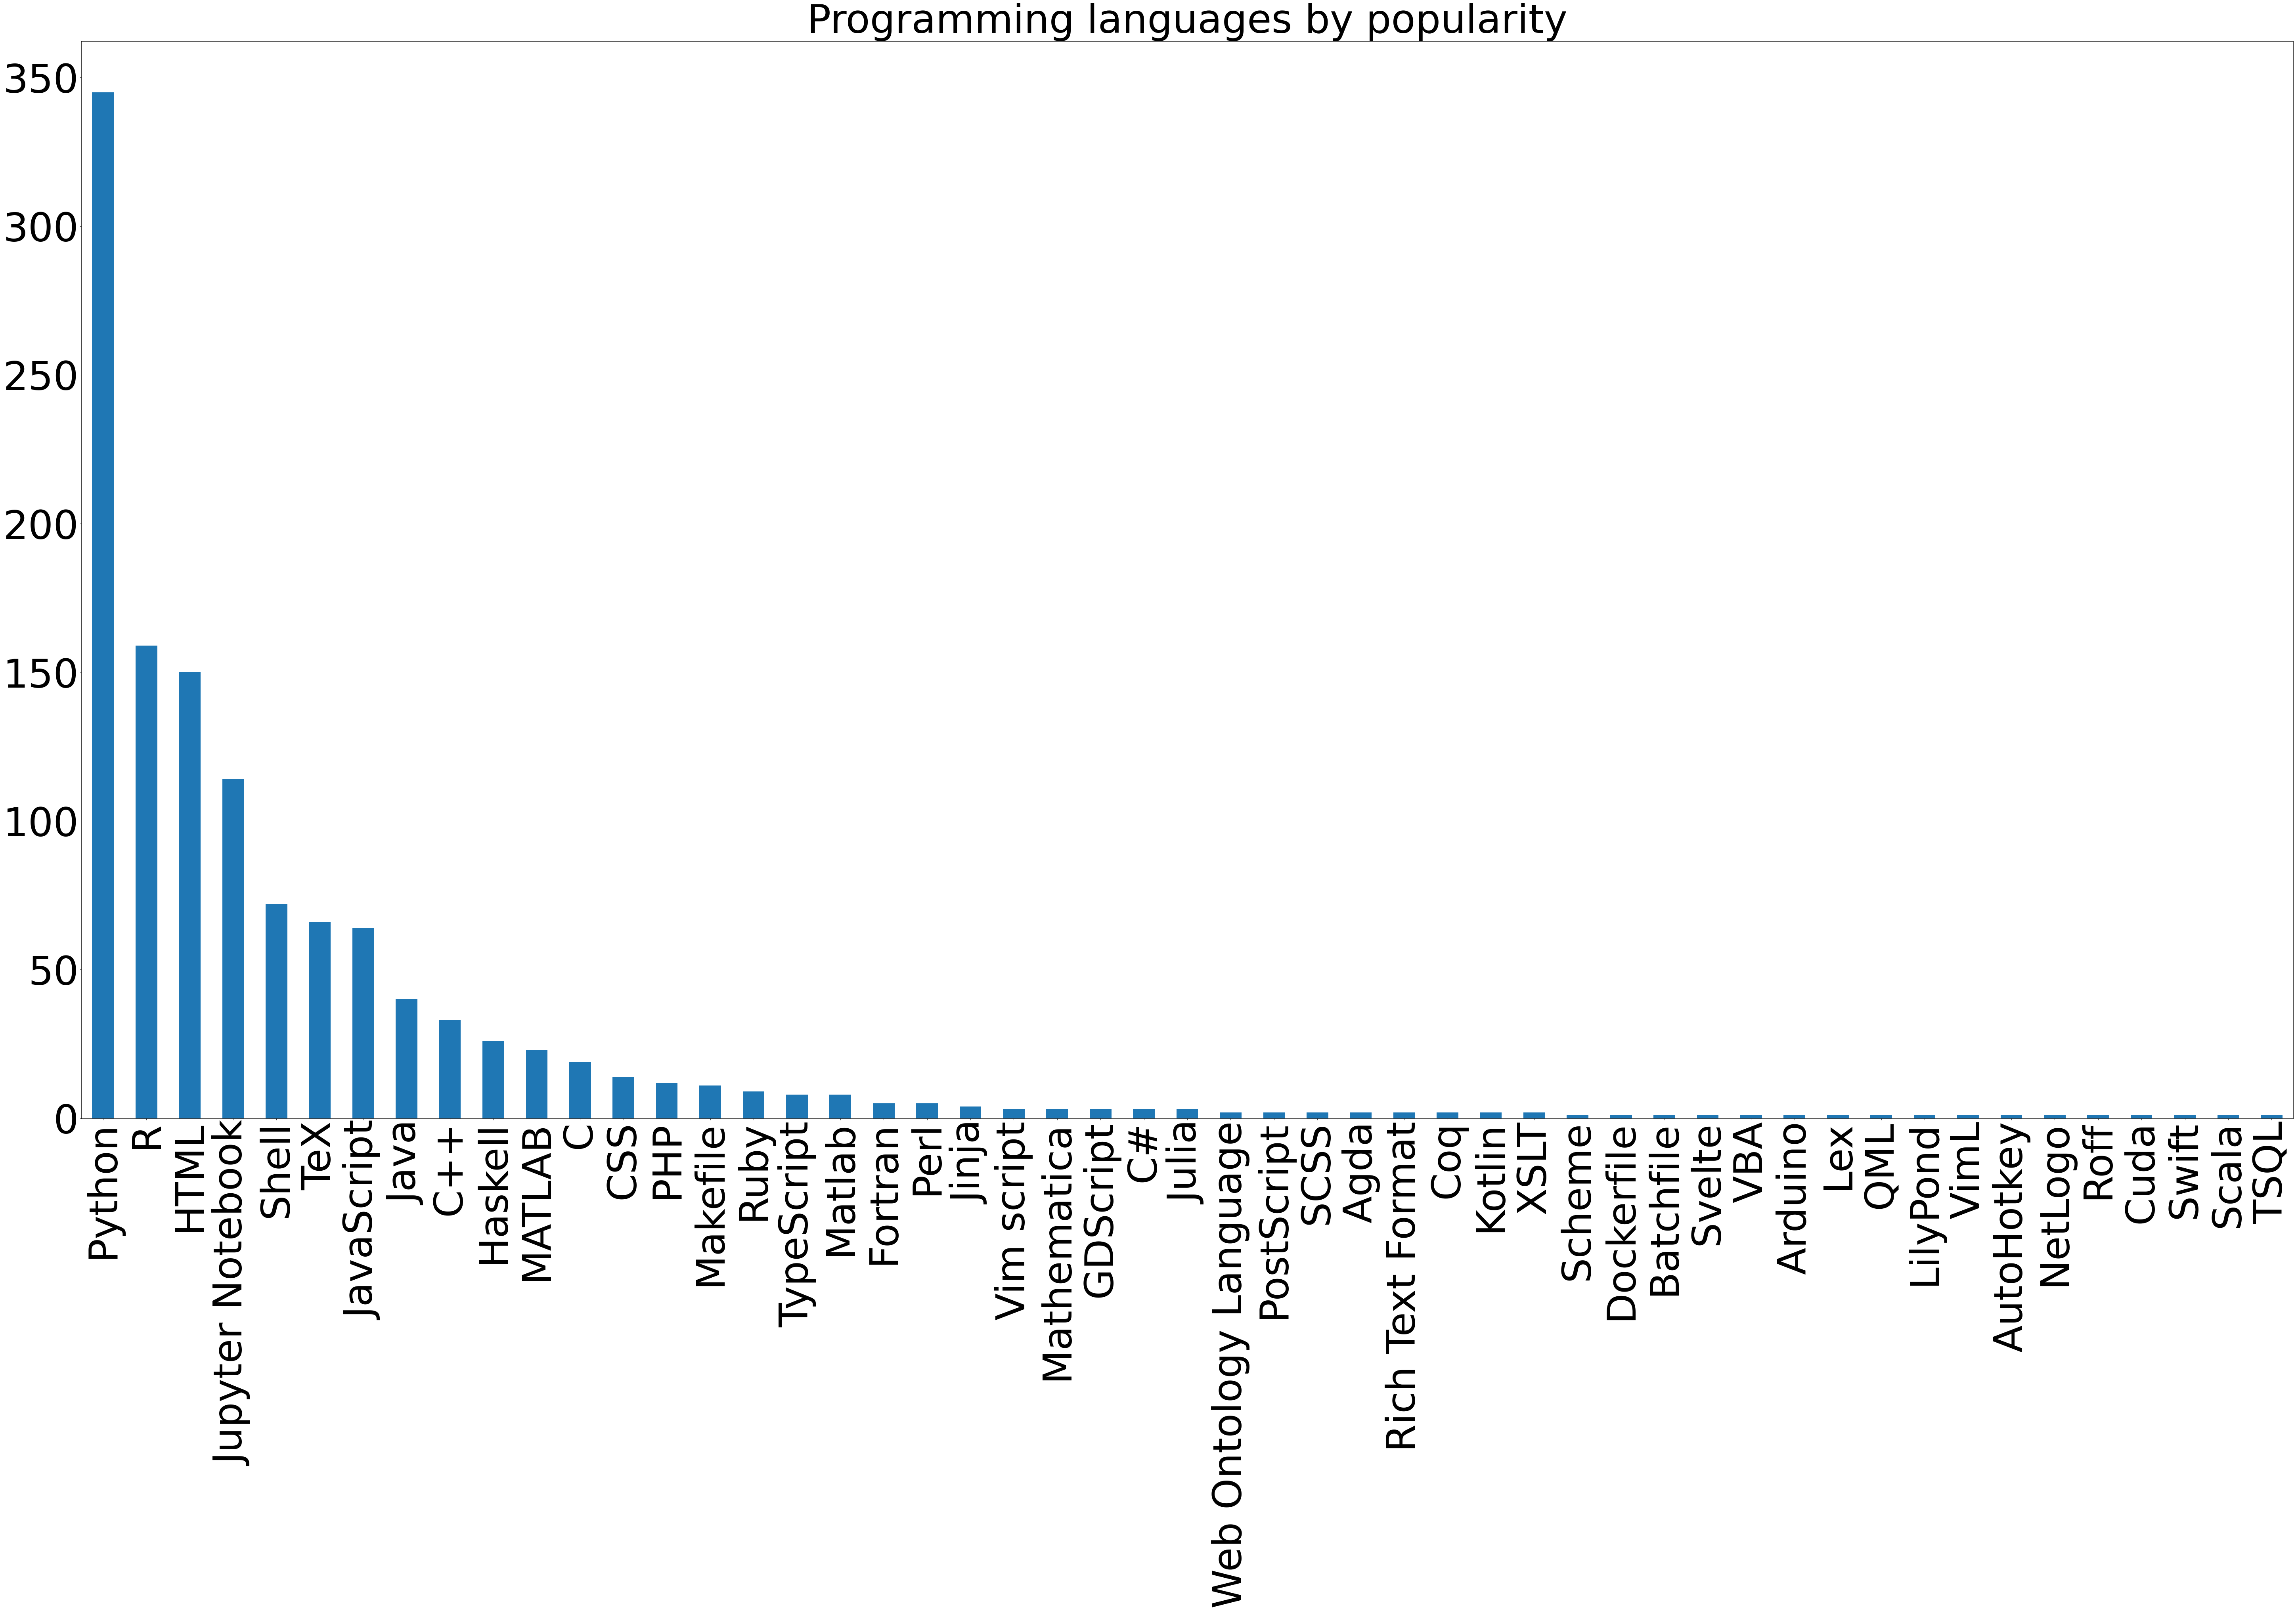

In [23]:
repos["language"].value_counts().plot.bar(figsize = (100,50), fontsize = 100)
plt.title("Programming languages by popularity", fontsize = 100)
plt.savefig(Path(fp_figs, f'language_{subset}.png'), bbox_inches="tight")

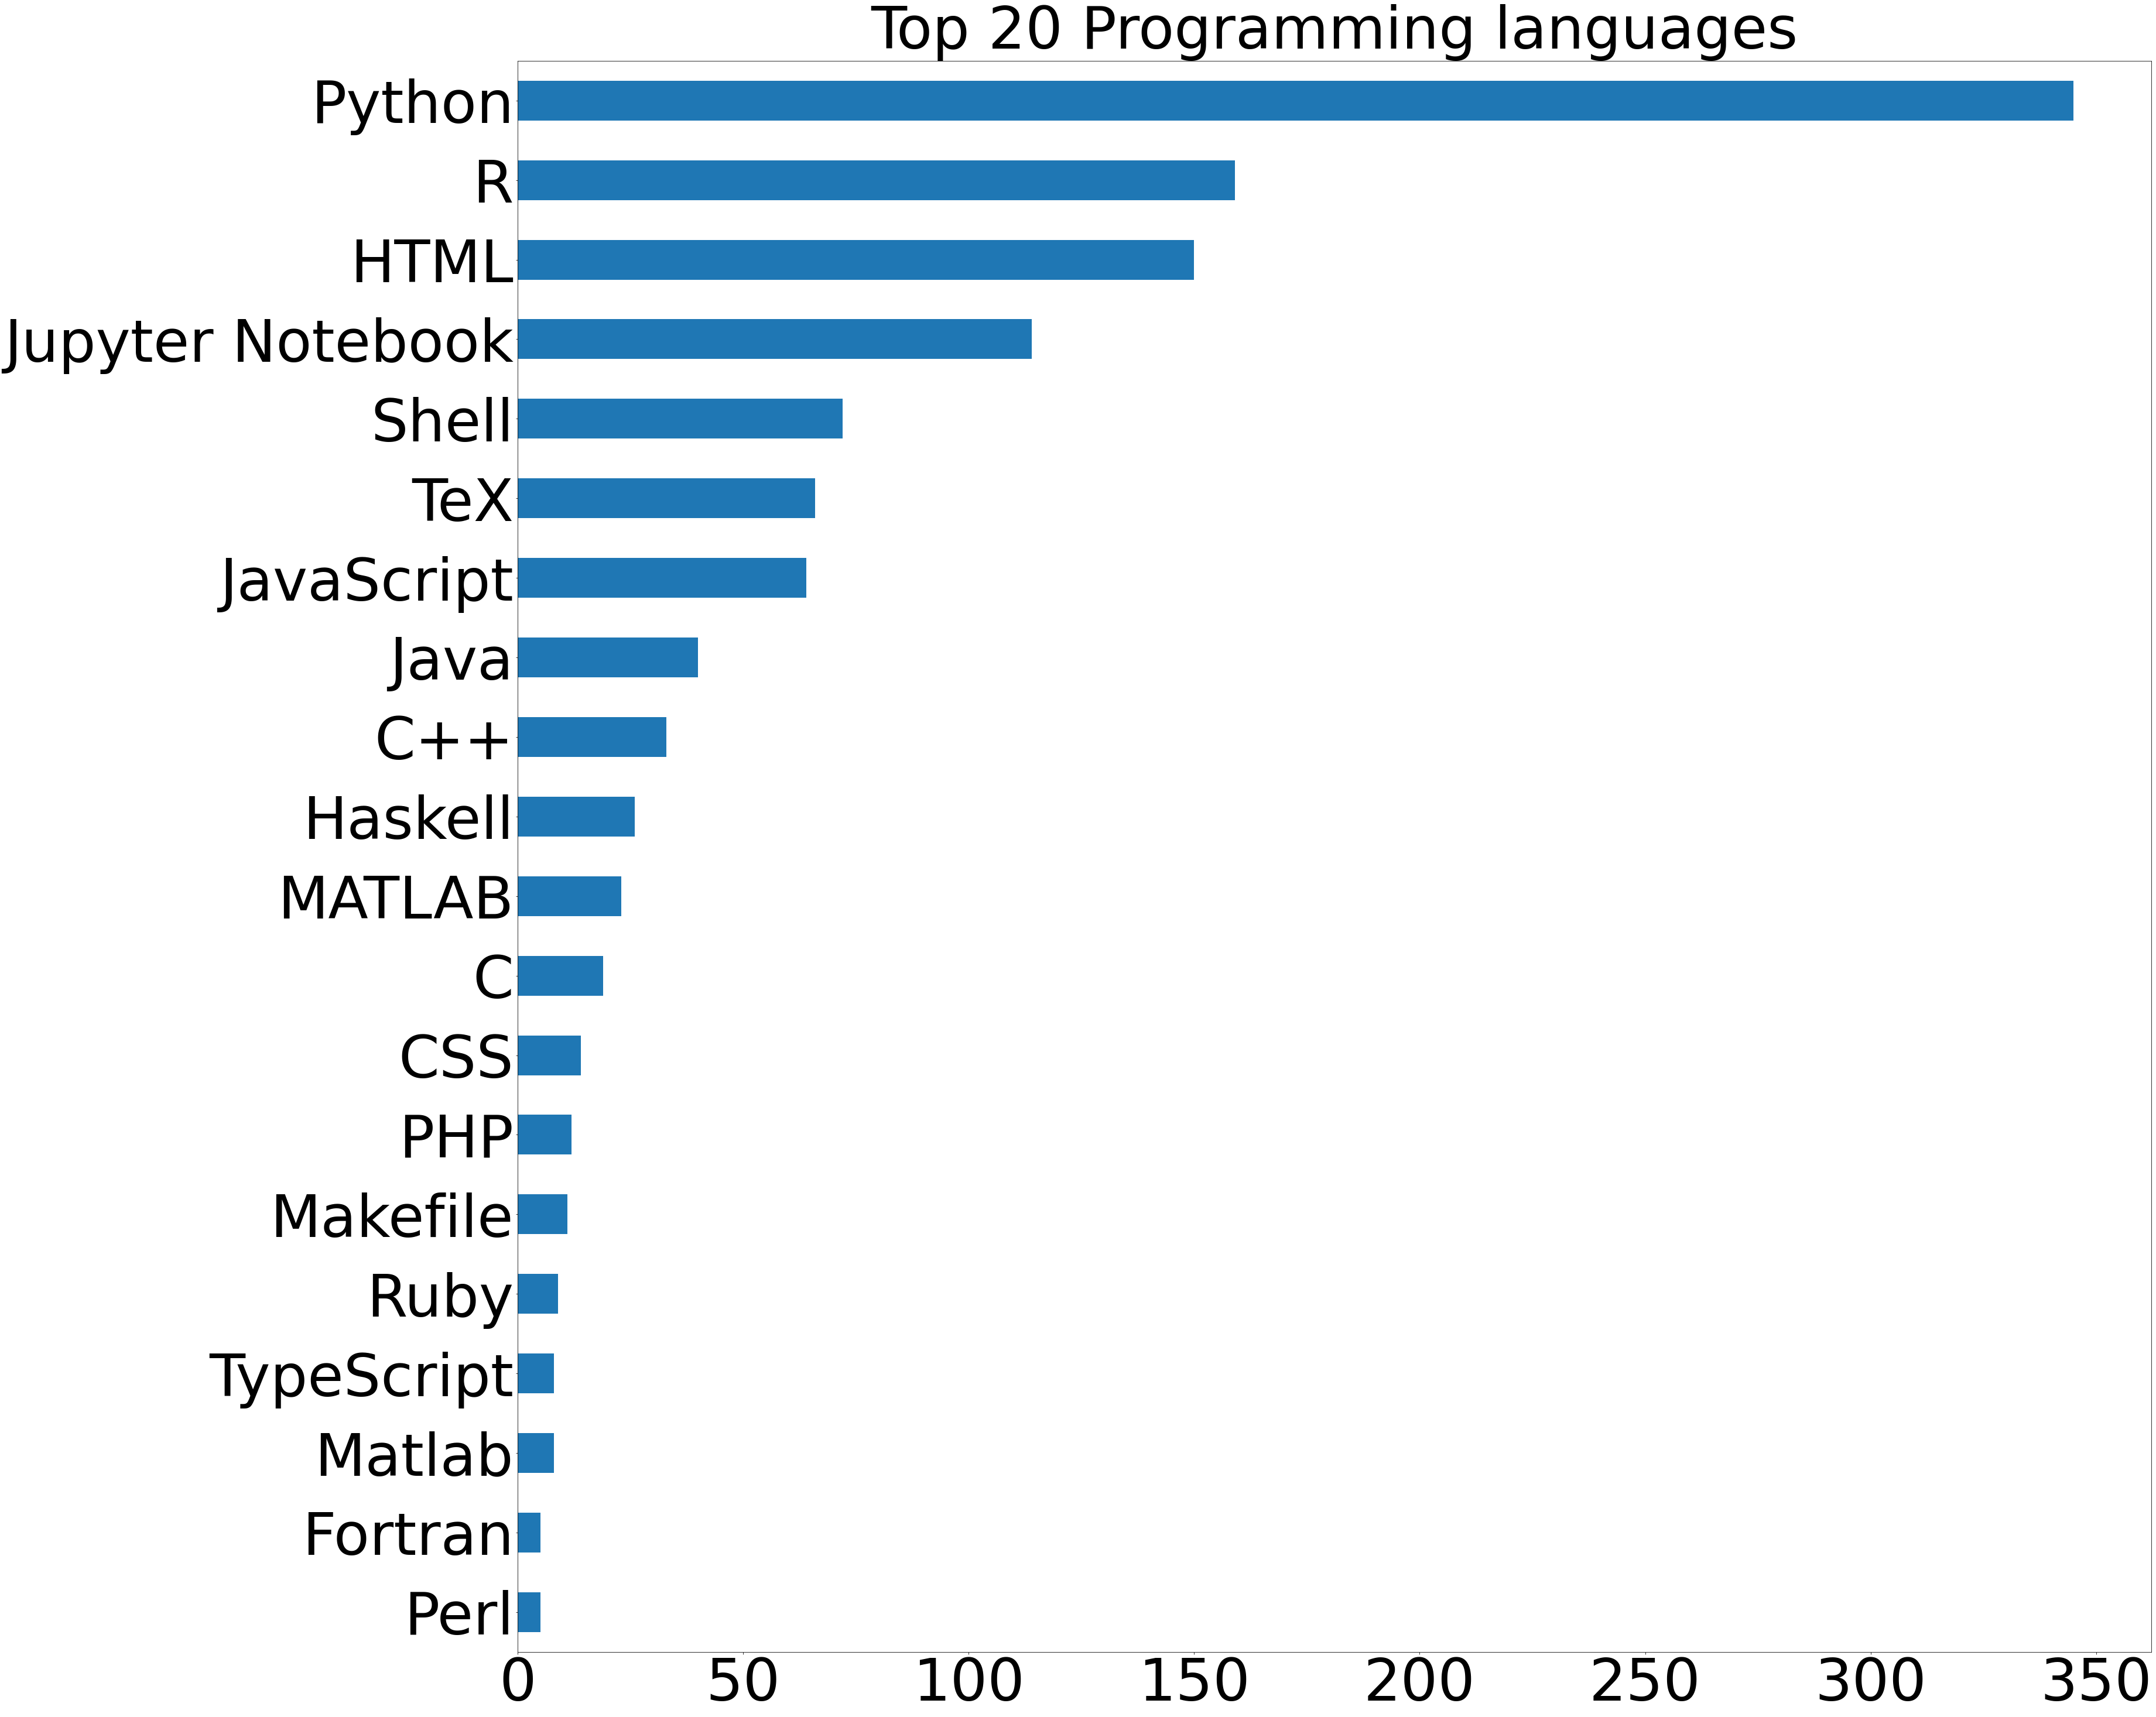

In [24]:
repos["language"].value_counts().head(20).plot.barh(figsize = (50,50), fontsize = 100)
plt.title("Top 20 Programming languages", fontsize = 100)
plt.gca().invert_yaxis()
plt.savefig(Path(fp_figs, f'language_top20_{subset}.png'), bbox_inches="tight")

/opt/homebrew/Caskroom/miniforge/base/envs/asreview_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


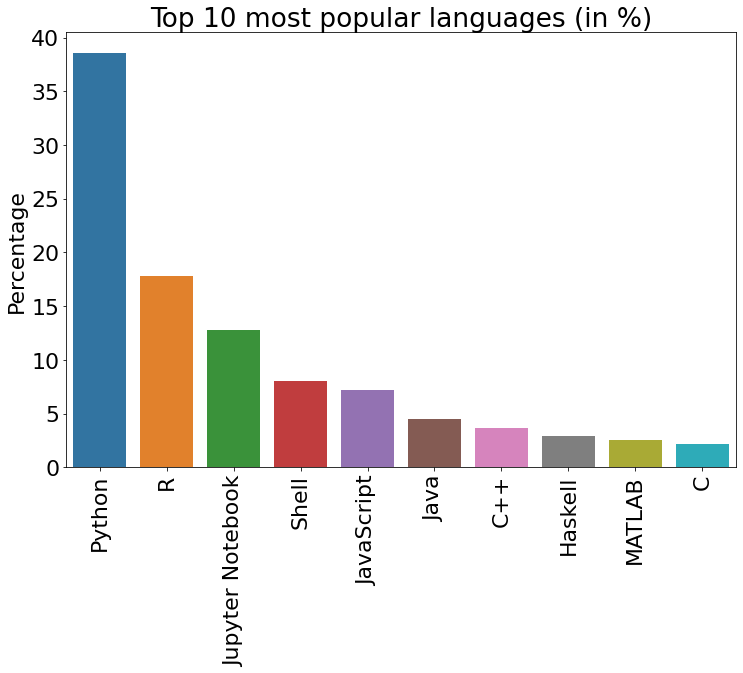

In [29]:
top_10_languages = repos["language"].value_counts().drop(["HTML", "TeX"]).head(10)

ax = sns.barplot(top_10_languages.index, top_10_languages / top_10_languages.sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular languages (in %)")

plt.savefig(Path(fp_figs, f'language_top10_{subset}.png'), bbox_inches="tight")

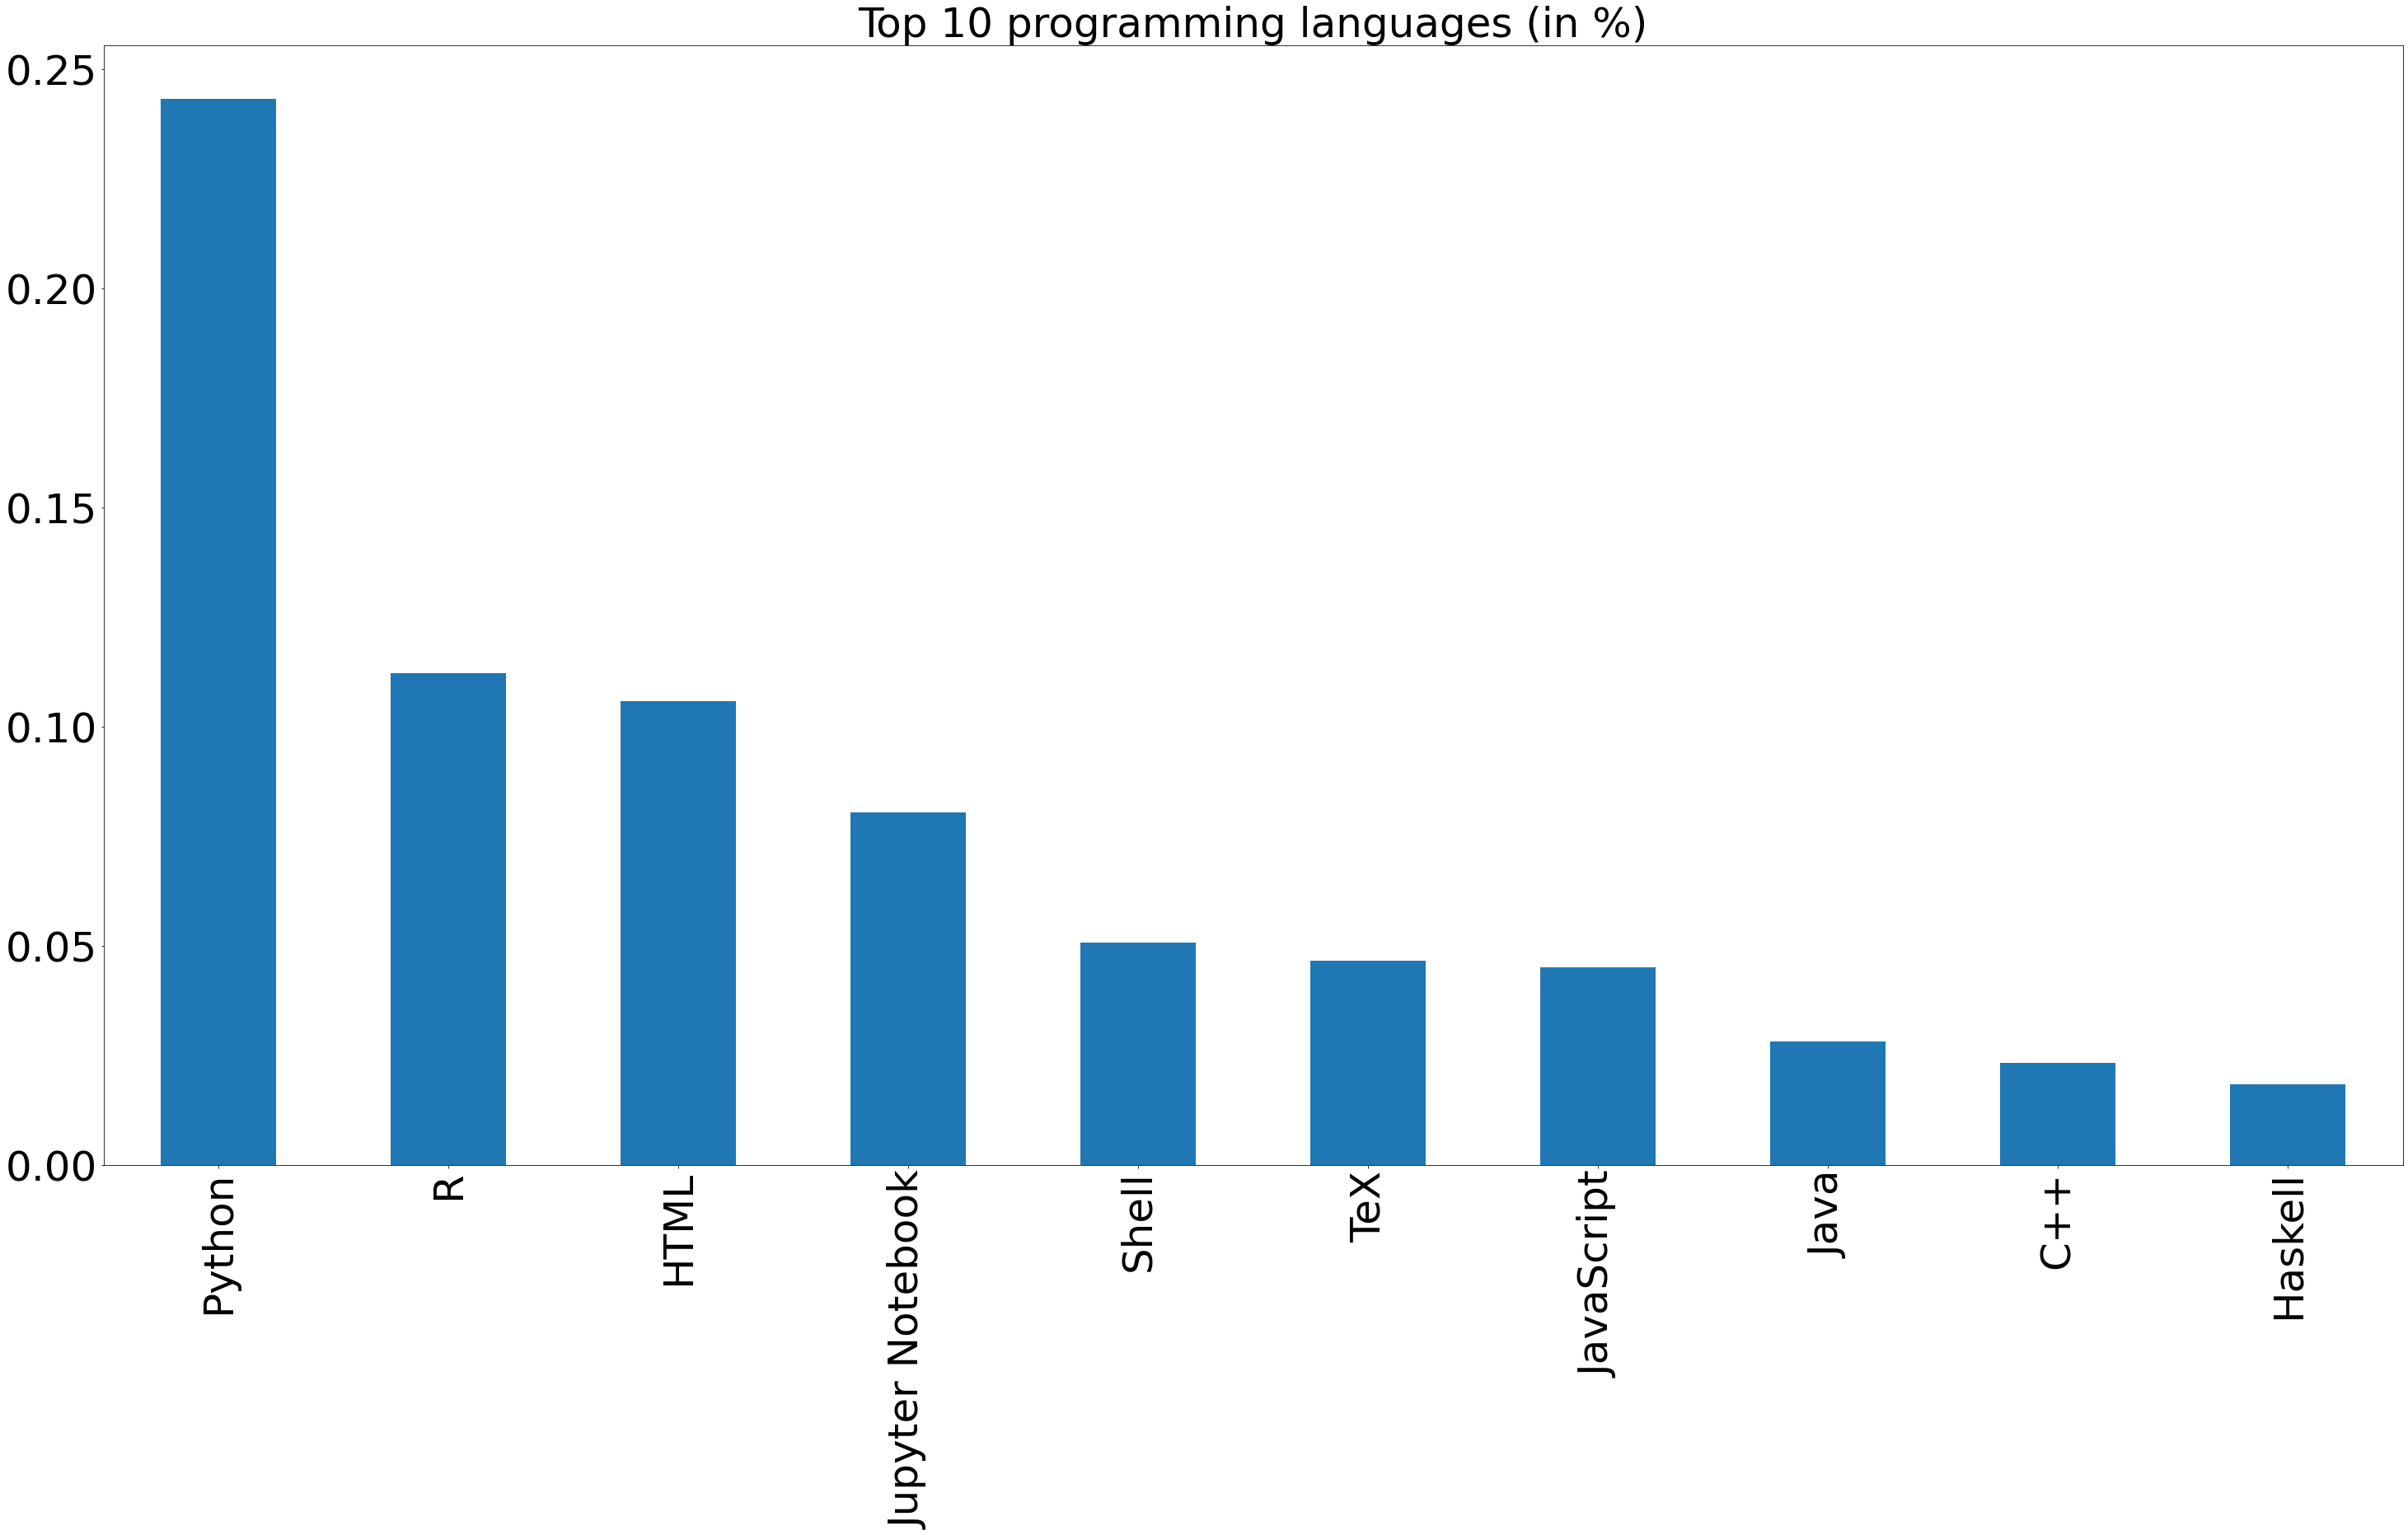

In [30]:
repo_languages_rel = repos["language"].value_counts().head(10) / len(repos)
repo_languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_percentage_{subset}.png'), bbox_inches="tight")


## Relative occurence languages

In [27]:
repo_languages_rel

Python              0.243300
R                   0.112130
HTML                0.105783
Jupyter Notebook    0.080395
Shell               0.050776
TeX                 0.046544
JavaScript          0.045134
Java                0.028209
C++                 0.023272
Haskell             0.018336
Name: language, dtype: float64

## The following percentages represent the percentage of repositories that contains that specific language for the 10 most occuring languages:

In [28]:
for value, language in zip(languages["language"].value_counts().head(10), languages["language"].value_counts().head(10).keys()):
    percentage = value / len(repos) * 100
    print("{} is present in {:.2f} % of all repositories". format(language, percentage))

Python is present in 36.04 % of all repositories
HTML is present in 20.80 % of all repositories
Shell is present in 19.46 % of all repositories
R is present in 19.18 % of all repositories
JavaScript is present in 11.57 % of all repositories
Jupyter Notebook is present in 10.08 % of all repositories
TeX is present in 10.01 % of all repositories
CSS is present in 9.45 % of all repositories
Makefile is present in 7.19 % of all repositories
C++ is present in 6.14 % of all repositories


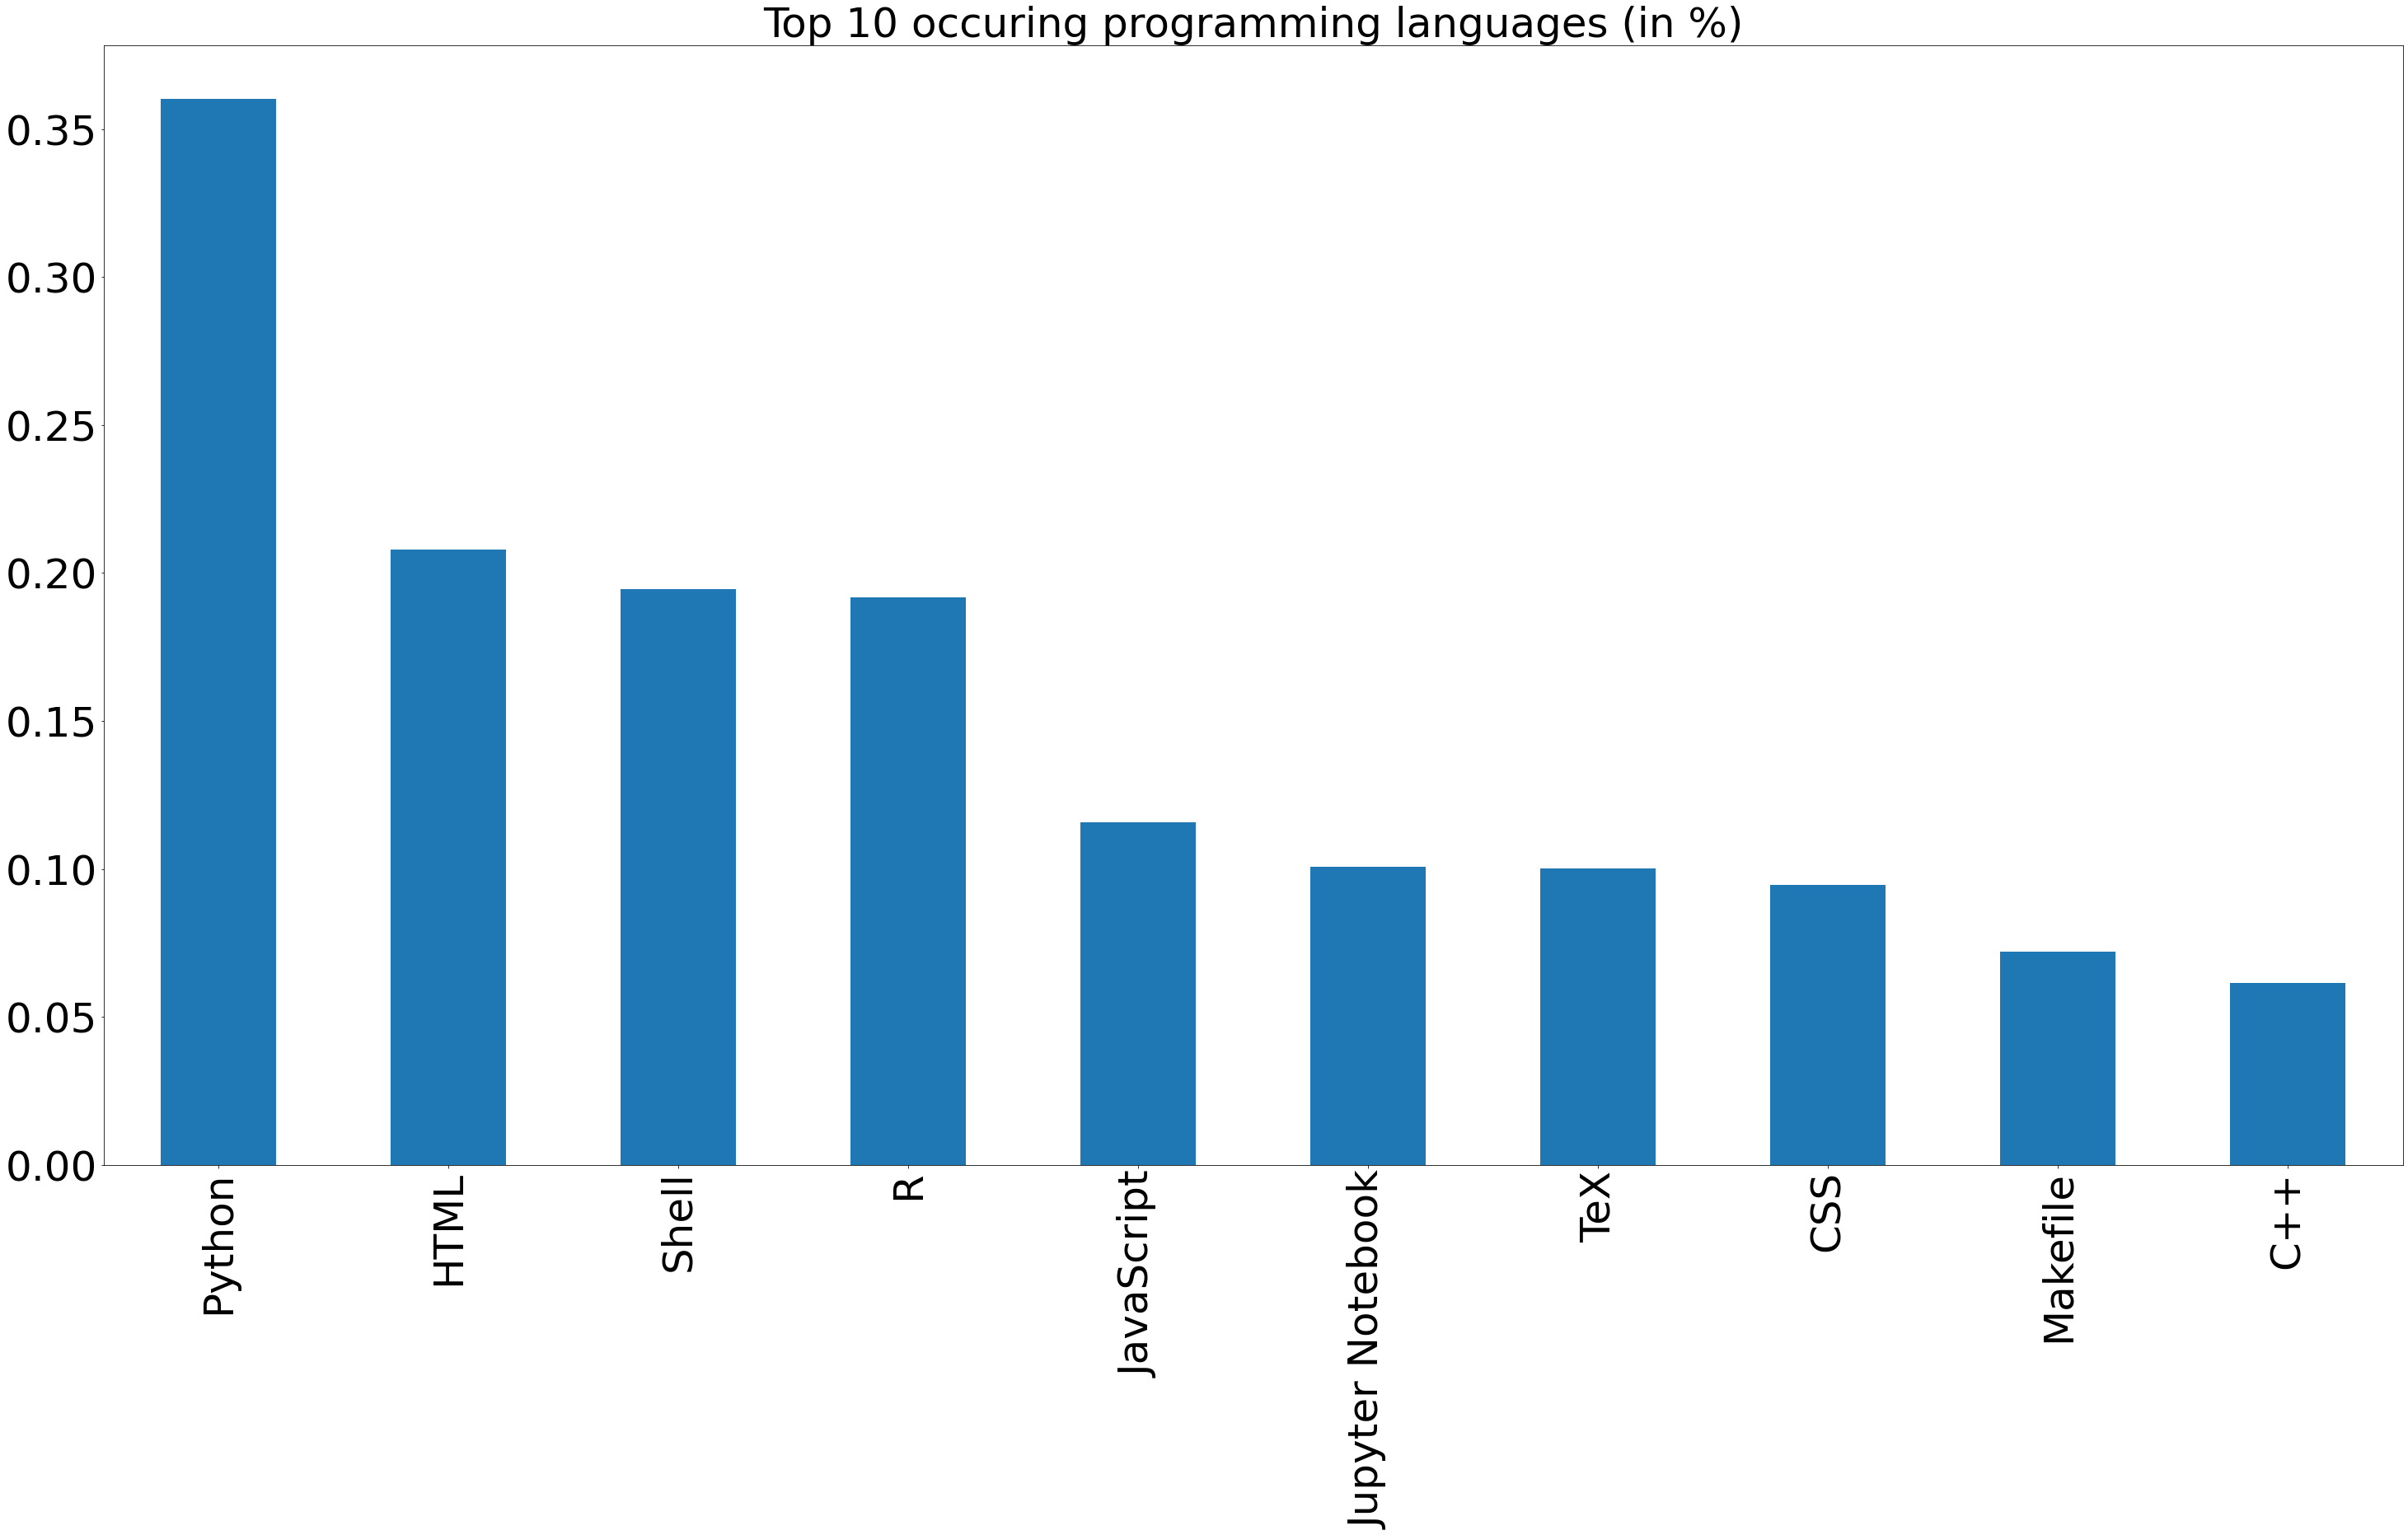

In [29]:
languages_rel = languages["language"].value_counts().head(10) / len(repos)
languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 occuring programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'occurence_language_top10_percentage_{subset}.png'), bbox_inches="tight")


In [30]:
languages["user"] = languages["html_url_repository"].map(lambda url: url.split("/")[3]) # extract user from url
languages["repo"] = languages["html_url_repository"].map(lambda url: url.split("/")[4]) # extract user from url
unique_users = set(languages["user"])
userlang_chars = dict()
for user in unique_users:
    repos_user = languages.loc[languages['user'] == user]
    repos_user_total_chars = sum(repos_user["num_chars"])
    for index, row in repos_user.iterrows():
        key = row[1] # select language
        if key not in userlang_chars:
            userlang_chars[key] = row["num_chars"]/repos_user_total_chars
        else:
            userlang_chars[key] += row["num_chars"]/repos_user_total_chars

### The following shows a plot with stacked percentage of language usage of a user
#### E.g.: User X has 100 repos written in Python --> Add 1.0 to Python bar. User Y has 1 repo written in R and 1 in C# --> Add 0.5 to R and 0.5 to C#

                  stacked_percentage
Jupyter Notebook           24.591400
Python                     22.507936
R                          11.910978
MATLAB                      7.151581
Java                        5.178053
C++                         4.779502
JavaScript                  3.971916
C                           2.996572
CSS                         2.247570
Mathematica                 2.065016


/opt/homebrew/Caskroom/miniforge/base/envs/asreview_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


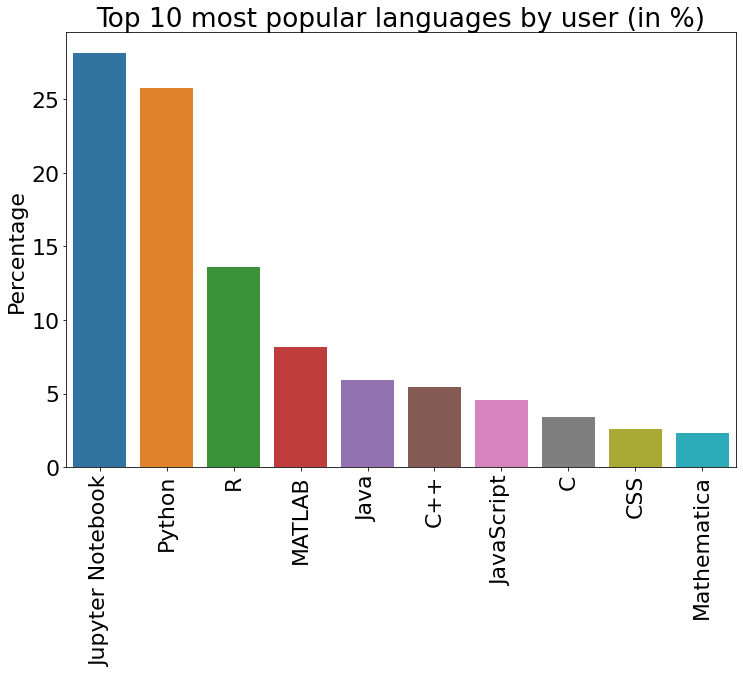

In [69]:
userlang_df = pd.DataFrame.from_dict(userlang_chars, orient="index", columns=['stacked_percentage'])
userlang_df.drop(["HTML", "TeX"], inplace = True)
userlang_df.sort_values(by="stacked_percentage", ascending = False, inplace = True)
userlang_df_top10 = userlang_df.head(10)
print(userlang_df_top10)

ax = sns.barplot(userlang_df_top10.index, userlang_df_top10["stacked_percentage"] / userlang_df_top10["stacked_percentage"].sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular languages by user (in %)")

plt.savefig(Path(fp_figs, f'most_occuring_languages_stacked_percent_top10_{subset}.png'), bbox_inches="tight")

## Correlation table top 10 languages

In [32]:
languages["language"].value_counts().head(10).keys()
dict_languages_user = Counter()
dict_top_languages = dict()
for language in languages["language"].value_counts().head(10).keys():
    dict_top_languages[language] = 0

In [33]:
dict_users = {}

In [34]:

for html_url in repos['html_url']: 
    #print(html_url)
    rows_language_for_one_user = languages.loc[languages['html_url_repository'] == html_url]
    dict_languages_user = Counter()
    for language in languages["language"].value_counts().head(10).keys(): #set all values of languages that need to be present to create a dataset in a later stage to zero
        dict_languages_user[language] = 0
    for language in rows_language_for_one_user['language']:
        if language in dict_languages_user: #only count languages in the top 10
            dict_languages_user[language] += 1
    dict_users[html_url] = dict_languages_user #each user has a dict with 10 booleans representing whether the top 10 language is present in their repo or not


In [35]:
languages_per_repo = pd.DataFrame.from_dict(dict_users, orient = 'index')

In [36]:
languages_per_repo.corr().round(decimals = 2)

,Python,HTML,Shell,R,JavaScript,Jupyter Notebook,TeX,CSS,Makefile,C++
Python,1.00,-0.10,0.14,-0.22,-0.05,0.22,-0.15,-0.00,0.06,0.02
HTML,-0.10,1.00,0.07,0.13,0.50,-0.06,0.13,0.51,-0.01,-0.04
Shell,0.14,0.07,1.00,-0.10,-0.02,0.01,-0.03,0.05,0.12,0.10
R,-0.22,0.13,-0.10,1.00,-0.05,-0.08,0.18,0.01,-0.02,-0.03
JavaScript,-0.05,0.50,-0.02,-0.05,1.00,-0.08,-0.00,0.64,0.00,-0.01
Jupyter Notebook,0.22,-0.06,0.01,-0.08,-0.08,1.00,-0.03,-0.08,-0.02,-0.07
TeX,-0.15,0.13,-0.03,0.18,-0.00,-0.03,1.00,0.09,0.17,-0.01
CSS,-0.00,0.51,0.05,0.01,0.64,-0.08,0.09,1.00,0.01,-0.01
Makefile,0.06,-0.01,0.12,-0.02,0.00,-0.02,0.17,0.01,1.00,0.42
C++,0.02,-0.04,0.10,-0.03,-0.01,-0.07,-0.01,-0.01,0.42,1.00


## Topics

Topics describe the context of the repository. 

In [37]:
topics['topic'].value_counts().nlargest(50)

utrecht-university               31
asreview                         22
python                           21
yoda                             16
irods                            13
james-server                     12
growth-curves                    10
php                               9
r                                 9
machine-learning                  9
growth-charts                     8
systematic-reviews                8
research                          8
open-science                      8
fiji-plugin                       7
netherlands                       7
codeigniter                       7
dutch                             7
mice                              6
anthropometry                     6
java                              5
eida                              5
imagej                            5
systematic-literature-reviews     5
microscopy                        5
imputation                        5
dataset                           5
deduplication               

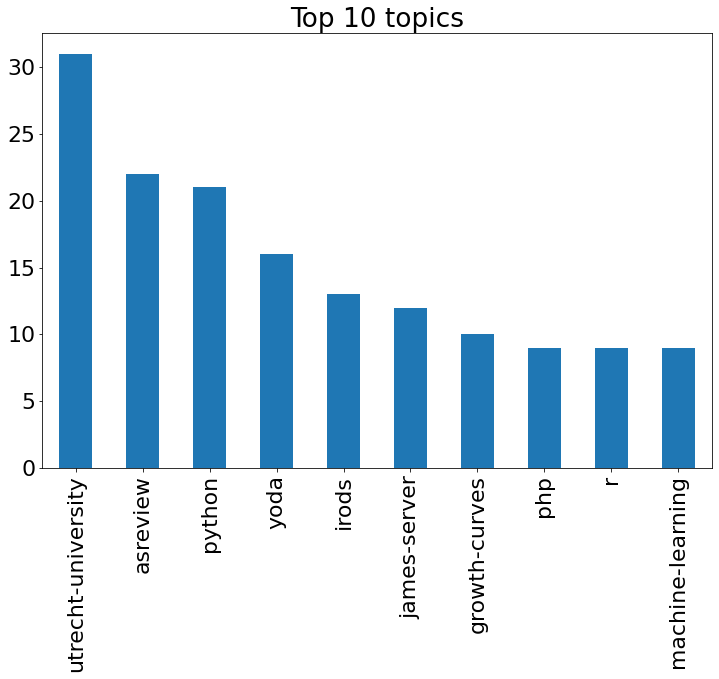

In [38]:
topics['topic'].value_counts().nlargest(10).plot(kind = 'bar', title = 'Top 10 topics')
plt.savefig(Path(fp_figs, f'most_occuring_topics_top10_{subset}.png'), bbox_inches="tight")


## Number of  contributors

The number of contributors gives information on how many people put effort into the repository. Theoratically, it would make sense if a higher amount of contributors implied a more FAIR repository, because those are easier to find in a registery and work on because of their license. 


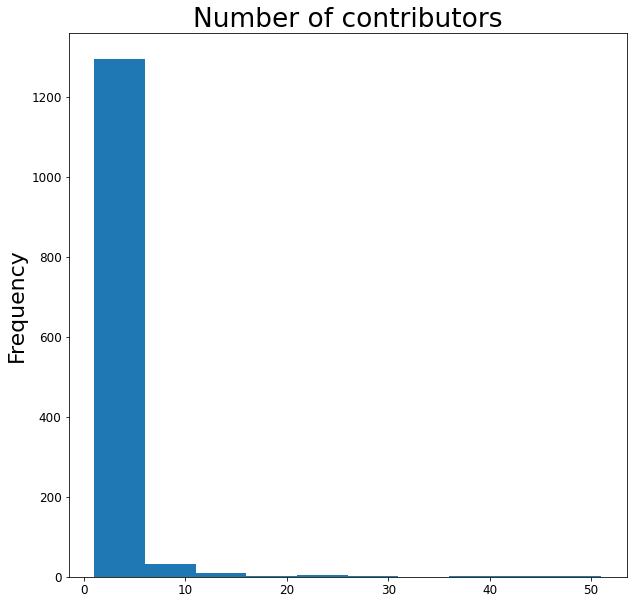

In [39]:
contributors['html_url_repository'].value_counts().plot.hist(x = 'contributors', figsize = (10,10), fontsize = 12, title = 'Number of contributors')
plt.savefig(Path(fp_figs, f'contributors_{subset}.png'), bbox_inches="tight")


In [40]:
contributors['html_url_repository'].value_counts().nlargest(20, keep = 'all')


https://github.com/aldertzomer/Microbial-Genomics-2021        51
https://github.com/aldertzomer/Microbial-Genomics-2019        51
https://github.com/leonardovida/gatsby-starter-netlify-cms    43
https://github.com/OceanParcels/parcels                       38
https://github.com/CLARIAH/clariah-plus                       29
https://github.com/asreview/asreview                          25
https://github.com/amices/mice                                24
https://github.com/UtrechtUniversity/dataprivacyproject       22
https://github.com/gerkovink/markup2020                       21
https://github.com/georkap/faster-rcnnwv.pytorch              18
https://github.com/J535D165/CoronaWatchNL                     17
https://github.com/UU-ComputerScience/uhc                     16
https://github.com/UtrechtUniversity/yoda                     15
https://github.com/CLARIAH/usecases                           15
https://github.com/iv4xr-project/TESTAR_iv4xr                 14
https://github.com/J535D1

In [41]:
print('mean contributors: {:.2f}'.format(statistics.mean(contributors['html_url_repository'].value_counts())))
print('median contributors: {}'.format(statistics.median(contributors['html_url_repository'].value_counts())))

mean contributors: 1.95
median contributors: 1


## Howfairis sum score descriptives and correlations

In this section, the median and meand of the howfairis sum score is shown, as well as correlations the how fair is sum score, the amount of contributors and the amount of months since the last commit

In [14]:
how_fair_sum_scores = []
for index, row in how_fair_is.iterrows():
    how_fair_is_sum = row['howfairis_repository'] + row['howfairis_license'] +row['howfairis_registry'] + row['howfairis_citation'] + row['howfairis_checklist']
    how_fair_sum_scores.append(how_fair_is_sum)

mean: 1.60
median: 2.0


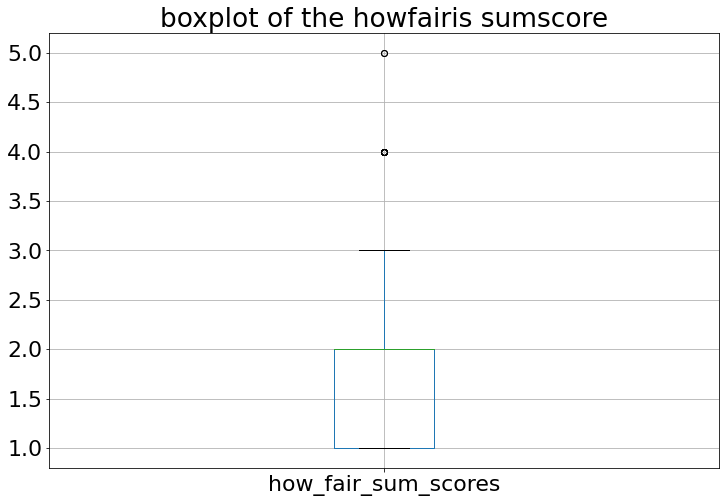

In [15]:
how_fair_is['how_fair_sum_scores'] = how_fair_sum_scores
print("mean: {:.2f}".format(statistics.mean(how_fair_sum_scores)))
print("median: {}".format(statistics.median(how_fair_sum_scores)))
pd.DataFrame((statistics.mean(how_fair_sum_scores), statistics.median(how_fair_sum_scores)),["mean", "median"])
how_fair_is.boxplot(column = 'how_fair_sum_scores')
plt.title('boxplot of the howfairis sumscore')
plt.savefig(Path(fp_figs, f'howfairissum_boxplot_{subset}.png'), bbox_inches="tight")


In [20]:
how_fair_is
how_fair_is = how_fair_is.loc[how_fair_is['owner'] == "UUDigitalHumanitieslab"]

1    17
2    24
3     4
Name: how_fair_sum_scores, dtype: int64


C:\Users\beld\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Score in howfairis tool @DHLab (in %)')

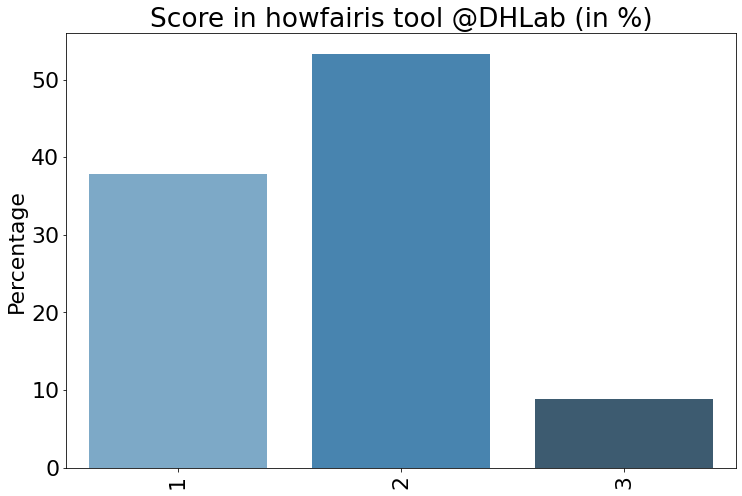

In [22]:
# how_fair_is['how_fair_sum_scores'].value_counts().sort_index().plot.bar(title = 'Scores howfairis')
# plt.savefig(Path(fp_figs, f'howfairissum_histogram_{subset}.png'), bbox_inches="tight")


howfairis_result = how_fair_is['how_fair_sum_scores'].value_counts().sort_index()
print(howfairis_result)

ax = sns.barplot(howfairis_result.index, howfairis_result / howfairis_result.sum() * 100, palette='Blues_d')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Score in howfairis tool @DHLab (in %)")

In [45]:
correlation_df = pd.DataFrame()
months_ago_most_recent_commit =[]
today = str(date.today())
split_today = today.split('-')
for date_item in repos['updated_at']:
    split_date = date_item.split('-')
    years_ago = int(split_today[0]) - int(split_date[0])
    months_ago = 12 * years_ago + (int(split_today[1]) - int(split_date[1]))
    months_ago_most_recent_commit.append(months_ago)
repos['months_ago_most_recent_commit'] = months_ago_most_recent_commit

In [46]:
correlation_df['how_fair_sum_scores'] = how_fair_sum_scores
correlation_df['contributions']= contributors['contributions']
correlation_df['months_ago_most_recent_commit'] = repos['months_ago_most_recent_commit']

In [47]:
correlation_df.corr(method='pearson').round(decimals=2)

,how_fair_sum_scores,contributions,months_ago_most_recent_commit
how_fair_sum_scores,1.00,-0.04,-0.24
contributions,-0.04,1.00,-0.02
months_ago_most_recent_commit,-0.24,-0.02,1.00


In [48]:
unique_users = set(how_fair_is["owner"])
unique_users
howfairis_max_user = list()
howfairis_average = list()
for user in unique_users:
    repos_user = how_fair_is.loc[how_fair_is['owner'] == user]
    howfairis_max_user.append(max(repos_user["how_fair_sum_scores"]))
    num_repos = len(repos_user.index)
    average = sum(repos_user["how_fair_sum_scores"])/num_repos
    howfairis_average.append([average, num_repos])

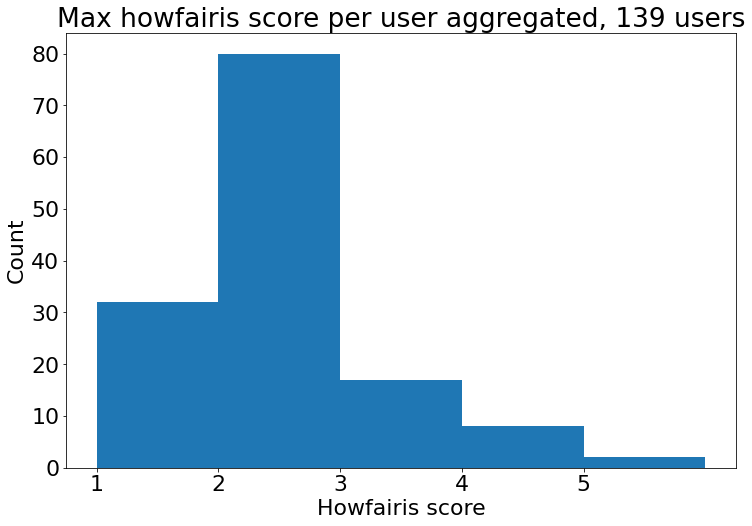

In [49]:
plt.hist(howfairis_max_user, bins = range(1,7))
plt.xticks(range(1,6))
plt.ylabel('Count')
plt.xlabel('Howfairis score')
plt.title("Max howfairis score per user aggregated, " + str(len(unique_users)) + " users")
plt.savefig(Path(fp_figs, f'howfairis_stacked_max{subset}.png'), bbox_inches="tight")

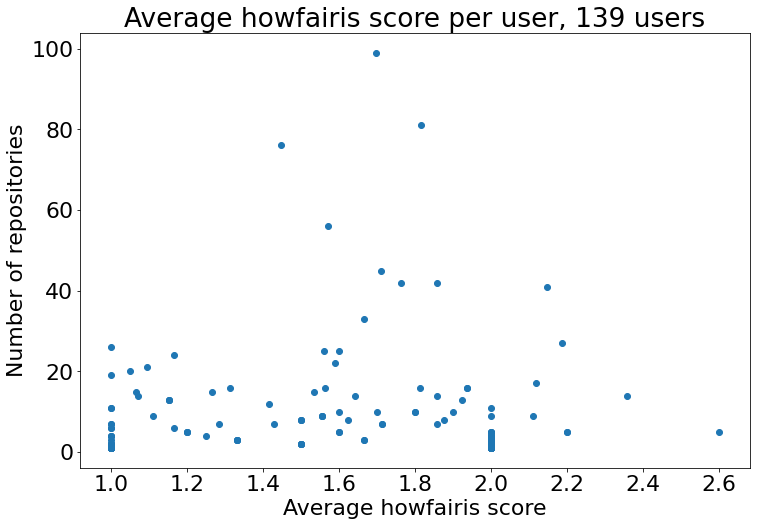

In [50]:
plt.scatter(*zip(*howfairis_average))
plt.ylabel('Number of repositories')
plt.xlabel('Average howfairis score')
plt.title("Average howfairis score per user, " + str(len(unique_users)) + " users")
plt.savefig(Path(fp_figs, f'howfairis_scatter_repos_avg{subset}.png'), bbox_inches="tight")

## Binary correlation plot between howfairis variables

A correlation table that shows the correlation between the howfairis measures.

In [51]:
correlation_how_fair_is = pd.DataFrame()

#correlation_how_fair_is['howfairis_repository'] = how_fair_is['howfairis_repository']
correlation_how_fair_is['howfairis_license'] = how_fair_is['howfairis_license']
correlation_how_fair_is['howfairis_registry'] = how_fair_is['howfairis_registry']
correlation_how_fair_is['howfairis_citation'] = how_fair_is['howfairis_citation']
correlation_how_fair_is['howfairis_checklist'] = how_fair_is['howfairis_checklist']



In [52]:
correlation_how_fair_is.corr(method='pearson').round(decimals=2) #howfairis_repository is all true, so has no variance

,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist
howfairis_license,1.00,0.10,0.14,0.06
howfairis_registry,0.10,1.00,0.14,0.31
howfairis_citation,0.14,0.14,1.00,0.15
howfairis_checklist,0.06,0.31,0.15,1.00


## Programming language and Howfairis

Different programming languages need different licences. For some languages (e.g. python), these are more complex. How does this influence the HowFairis score?

In [53]:
index_how_fair_is = 0
language_how_fair_is_df = []
#get a list with the how-fair-is scores added to the language dataset
for index,row in languages.iterrows():
    if how_fair_is['html_url'][index_how_fair_is] != languages['html_url_repository'][index]:
        index_how_fair_is += 1 
    sum_score = how_fair_is['how_fair_sum_scores'][index_how_fair_is]
    language_how_fair_is_df.append(sum_score)
regression_data_how_fair_is_language = pd.DataFrame()
language_data_dummies = pd.get_dummies(languages['language'])  #one hot-encoding for language dataset
regression_data_how_fair_is_language['how_fair_is_sum'] = language_how_fair_is_df
languages['how_fair_sum_scores'] = regression_data_how_fair_is_language #add scores to language dataset

In [54]:
train_size = int(len(languages) * 0.8) #training size is 2227, testing size is  557
regression_how_fair_is_language_train_X = language_data_dummies[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_data_dummies[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [55]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
#print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


Mean squared error: 28090363172958641256923136.00
Coefficient of determination: -76093564631798217093152768.00


In [56]:
language_subset = language_data_dummies[['Python', 'Shell', 'R', 'JavaScript', 'HTML']] #top 5 languages


In [57]:
train_size = int(len(language_subset) * 0.8)
regression_how_fair_is_language_train_X = language_subset[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_subset[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [58]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


Coefficients: 
 [ 0.0285307  -0.01431516  0.00630561 -0.13171145 -0.10073443]
Mean squared error: 0.39
Coefficient of determination: -0.05


A simple regression for predicting the how fair is score from  all or a subset of languages does not seem to yield any results 

## Examples of high howfairis scores 

In this section, some links to the pages that have a high howfairis score are shown. 

In [59]:
how_fair_is_high_scores = how_fair_is[how_fair_is['how_fair_sum_scores'] > 3].sort_values('how_fair_sum_scores', ascending=False)

how_fair_is_high_scores[['html_url', 'how_fair_sum_scores']]

,html_url,how_fair_sum_scores
903,https://github.com/OceanParcels/parcels,5
970,https://github.com/puregome/notebooks,5
88,https://github.com/asreview/asreview,4
154,https://github.com/cjvanlissa/bain,4
206,https://github.com/cjvanlissa/worcs,4
227,https://github.com/CLARIAH/grlc,4
289,https://github.com/computationalgeography/lue,4
311,https://github.com/D-score/childdevdata,4
545,https://github.com/haddocking/pdb-tools,4
629,https://github.com/J535D165/recordlinkage,4


## Re-use of other projects and articles

Are there competitors?
How do they relate to each other?

## Installation statistics

In [80]:
installations[installations["repository_name"] != "pcalg"].sort_values("last_month", ascending=False).reset_index(drop=True).drop("date", axis=1)

,repository_name,owner,last_month
0,recordlinkage,J535D165,156001
1,mice,amices,40298
2,cbsodata,J535D165,2473
3,asreview,asreview,873
4,tidySEM,cjvanlissa,865
5,pdb-tools,haddocking,825
6,bain,cjvanlissa,799
7,pema,cjvanlissa,467
8,AGD,stefvanbuuren,444
9,brokenstick,growthcharts,430
